# Maven Fuzzy Factory – E-Commerce Growth & Conversion Dashboard


In [ ]:
To analyze e-commerce website performance by evaluating traffic trends, conversion efficiency, marketing channel effectiveness, and product revenue contribution using an interactive Power BI dashboard, enabling data-driven business decisions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
sessions=pd.read_csv("website_sessions.csv")
pageviews=pd.read_csv("website_pageviews.csv")
orders=pd.read_csv("orders.csv")
order_items=pd.read_csv("order_items.csv")
refunds=pd.read_csv("order_item_refunds.csv")
products=pd.read_csv("products.csv")

In [3]:
# convert data columns
date_cols = {
    'sessions': (sessions, ['created_at']),
    'pageviews': (pageviews, ['created_at']),
    'orders': (orders, ['created_at']),
    'order_items': (order_items, ['created_at']),
    'refunds': (refunds, ['created_at'])
}

for name, (df, cols) in date_cols.items():
    for col in cols:
        df[col] = pd.to_datetime(df[col])


In [4]:
# basic checks
print(sessions.info())
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472871 entries, 0 to 472870
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   website_session_id  472871 non-null  int64         
 1   created_at          472871 non-null  datetime64[ns]
 2   user_id             472871 non-null  int64         
 3   is_repeat_session   472871 non-null  int64         
 4   utm_source          389543 non-null  object        
 5   utm_campaign        389543 non-null  object        
 6   utm_content         389543 non-null  object        
 7   device_type         472871 non-null  object        
 8   http_referer        432954 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 32.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32313 entries, 0 to 32312
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------             

In [8]:
session_orders = sessions.merge(
    orders,
    on="website_session_id",
    how="left"
)


In [11]:
# add order items
order_revenue = order_items.groupby("order_id", as_index=False)["price_usd"].sum()
order_revenue.rename(columns={"price_usd": "order_revenue"}, inplace=True)

session_orders = session_orders.merge(
    order_revenue,
    on="order_id",
    how="left"
)

session_orders["order_revenue"] = session_orders["order_revenue"].fillna(0)

In [12]:
# kpi creation

total_sessions = session_orders["website_session_id"].nunique()
total_orders = session_orders["order_id"].nunique()
total_revenue = session_orders["order_revenue"].sum()

conversion_rate = total_orders / total_sessions
revenue_per_order = total_revenue / total_orders
revenue_per_session = total_revenue / total_sessions

print("Total Sessions:", total_sessions)
print("Total Orders:", total_orders)
print("Conversion Rate:", round(conversion_rate, 4))
print("Revenue per Order:", round(revenue_per_order, 2))
print("Revenue per Session:", round(revenue_per_session, 2))

Total Sessions: 472871
Total Orders: 32313
Conversion Rate: 0.0683
Revenue per Order: 59.99
Revenue per Session: 4.1


In [13]:
# monthly trend

session_orders["month"] = session_orders["created_at_x"].dt.to_period("M")

monthly_metrics = session_orders.groupby("month").agg(
    sessions=("website_session_id", "nunique"),
    orders=("order_id", "nunique"),
    revenue=("order_revenue", "sum")
).reset_index()

monthly_metrics["conversion_rate"] = (
    monthly_metrics["orders"] / monthly_metrics["sessions"]
)

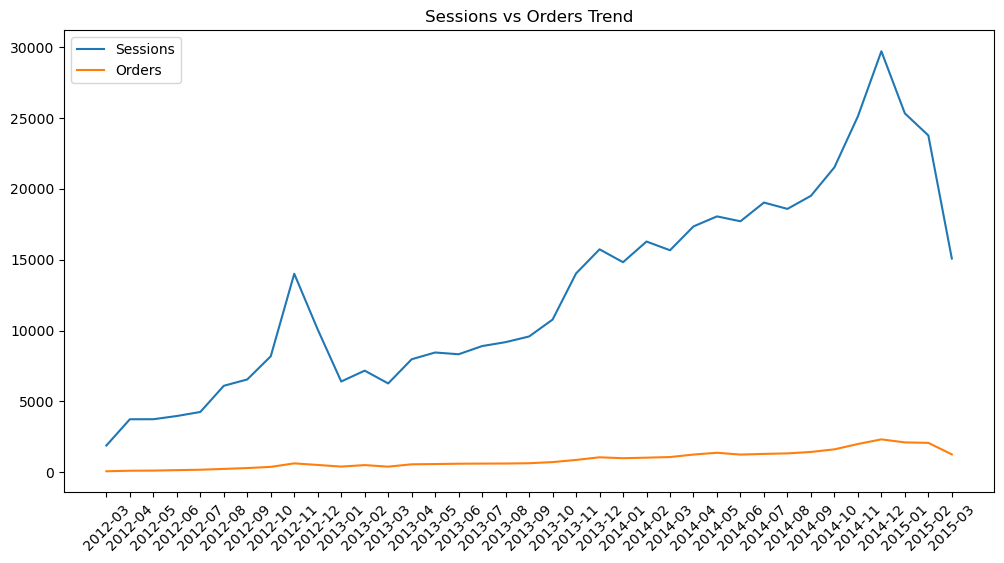

In [14]:
# plot trends
plt.figure(figsize=(12,6))
plt.plot(monthly_metrics["month"].astype(str),
         monthly_metrics["sessions"], label="Sessions")
plt.plot(monthly_metrics["month"].astype(str),
         monthly_metrics["orders"], label="Orders")
plt.xticks(rotation=45)
plt.title("Sessions vs Orders Trend")
plt.legend()
plt.show()


In [15]:
# Channel Performance

channel_perf = session_orders.groupby("utm_source").agg(
    sessions=("website_session_id", "nunique"),
    orders=("order_id", "nunique"),
    revenue=("order_revenue", "sum")
).reset_index()

channel_perf["conversion_rate"] = (
    channel_perf["orders"] / channel_perf["sessions"]
)

channel_perf["revenue_per_session"] = (
    channel_perf["revenue"] / channel_perf["sessions"]
)

print(channel_perf.sort_values("revenue", ascending=False))


   utm_source  sessions  orders     revenue  conversion_rate  \
1     gsearch    316035   21333  1276144.89         0.067502   
0     bsearch     62823    4519   268672.50         0.071932   
2  socialbook     10685     343    22259.33         0.032101   

   revenue_per_session  
1             4.037986  
0             4.276658  
2             2.083232  


In [16]:
# Refund Analysis

refund_summary = refunds.merge(order_items, on="order_item_id", how="left")

refund_rate = (
    refund_summary["order_item_id"].nunique() /
    order_items["order_item_id"].nunique()
)

print("Refund Rate:", round(refund_rate, 4))

Refund Rate: 0.0432


In [18]:
# Start from sessions + orders (already fixed)
fact_table = sessions.merge(
    orders,
    on="website_session_id",
    how="left"
)

# Aggregate order_items to order level
order_revenue = (
    order_items
    .groupby("order_id", as_index=False)
    .agg(
        total_revenue=("price_usd", "sum"),
        total_cogs=("cogs_usd", "sum"),
        items_count=("order_item_id", "count")
    )
)

# Merge revenue into fact table
fact_table = fact_table.merge(
    order_revenue,
    on="order_id",
    how="left"
)

# Fill numeric nulls
fact_table[["total_revenue","total_cogs","items_count"]] = (
    fact_table[["total_revenue","total_cogs","items_count"]].fillna(0)
)

fact_table.to_csv("fact_ecommerce.csv", index=False)
